In [1]:
from __future__ import print_function
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  

# Boils down to "If I pick nodes (rf - 1) * vnode times, how many
# distinct nodes will I have in expectation. Note that this is a slightly
# optimistic estimate because Cassandra won't place two replicas of the
# same token on the same machine or rack, but this is close enough for
# the model
# This is a variant of the Birthday Problem where we are insterested
# in the number of distinct values produced
# http://www.randomservices.org/random/urn/Birthday.html
def num_neighbors(n, v, rf):
    k = v * (rf - 1)
    # As cassandra is rack aware, we assume #racks == #replicas
    # This is maybe a bad assumption for some datacenter deployments
    n = n - (n / rf)
    estimate = n * (1.0 - (1.0 - 1.0/n) ** k)
    return max(rf - 1, min(estimate, n))

def p_outage_given_failure(recovery, num_neighbors, rate):
    x =  math.exp(-1 * recovery * num_neighbors * rate)
    return 1 - x

def exp_failures(num_nodes, rate, year):
    return num_nodes * rate * year

def recovery_c(size, bw_in, bw_out, neighbors):
    return int(size / (min(bw_in, neighbors * bw_out)))

nodes = 96
vnodes = 256
rf = 3
# 1000 gigabytes
node_dataset_mb = 300 * 1024
# MB/s
bw_in = 125
bw_out = 25

year = 60.0*60*24*365
arate = 0.25 / year


print("\nFailure Rate Variability")
neighbors = num_neighbors(nodes, vnodes, rf)
print("Neighbors for {0} vnodes: {1}".format(vnodes, neighbors))
recovery = recovery_c(node_dataset_mb, bw_in, bw_out, neighbors)

for i in (0.125, 0.25, 0.5, 1, 2):
    rate = i / (year)
    failures = exp_failures(nodes, rate, year)
    probability = p_outage_given_failure(recovery, neighbors, rate)

    p = "{0:.3f} {1:.2f} {2:.6f} {3:.6f}".format(
        i, failures, probability, failures * probability
    )
    print(p)


def compute_outage(vnodes, failure_rate, num_nodes, rf, bw_in, bw_out):
    neighbors = num_neighbors(num_nodes, vnodes, rf)
    recovery = recovery_c(node_dataset_mb, bw_in, bw_out, neighbors)
    failures = exp_failures(num_nodes, failure_rate, year)
    probability = p_outage_given_failure(recovery, neighbors, failure_rate)
    #p = "{0} {1:.2f} {2:.6f} {3:.6f}".format(
    #    vnodes, neighbors, probability, failures * probability
    #)
    #if vnodes < 32 or vnodes > 255:
    #    print(p)
    return failures * probability



Failure Rate Variability
Neighbors for 256 vnodes: 63.9798444518
0.125 12.00 0.000623 0.007475
0.250 24.00 0.001245 0.029890
0.500 48.00 0.002489 0.119485
1.000 96.00 0.004972 0.477343
2.000 192.00 0.009920 1.904627


[0.0005844606522886764, 0.0005842850671888833, 0.000674353101373093]
[0.0023377856767785588, 0.0023370833705840255, 0.0026973366134770416]
[0.005259889679066099, 0.0052583095670768465, 0.006068836854671744]
[0.00935068727029531, 0.009347878319111658, 0.010788740151838283]


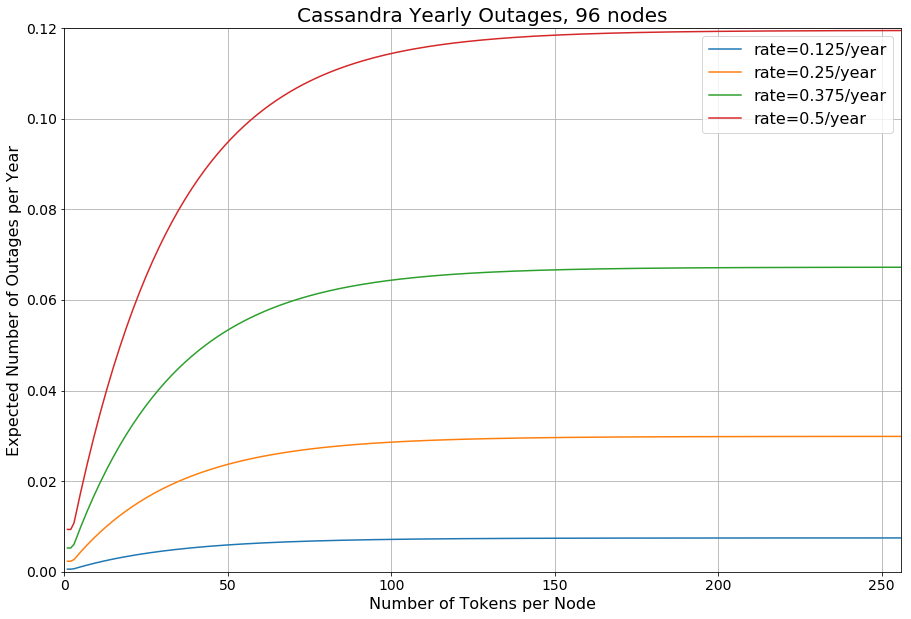

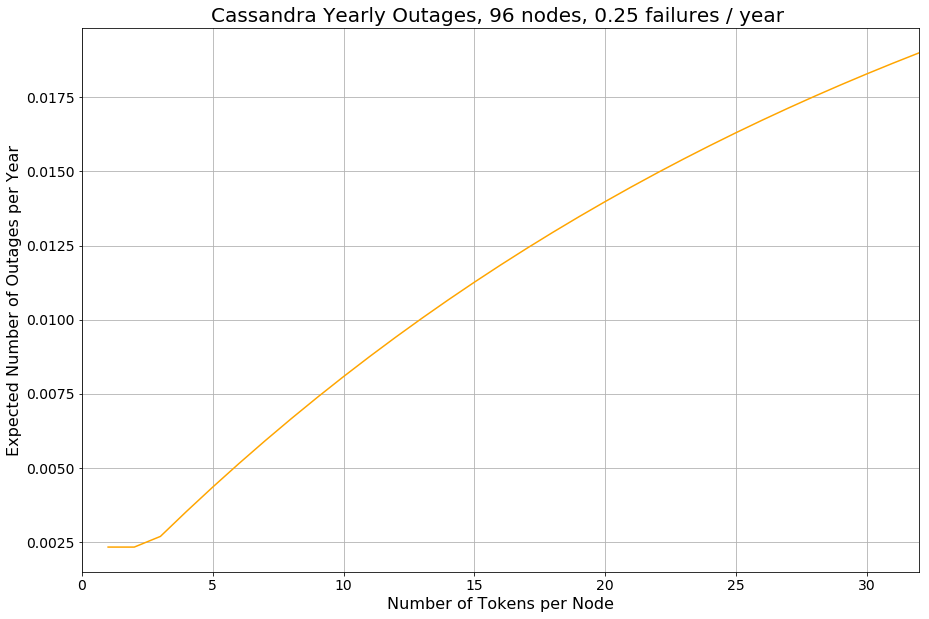

In [2]:
plt.figure(figsize=(15,10))
plt.title("Cassandra Yearly Outages, {0} nodes".format(nodes, arate * year), fontsize=20)
plt.ylabel("Expected Number of Outages per Year", fontsize=16)
plt.xlabel("Number of Tokens per Node", fontsize=16)
plt.xlim(0, 256)
plt.ylim(0, 0.12)
plt.gca().grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)

num_vnodes = range(1, 257)
rates = [x / year for x in (0.125, 0.250, 0.375, 0.5)]
for rate in rates:
    outages = []
    for vnode in num_vnodes:
        outages.append(compute_outage(vnode, rate, nodes, rf, bw_in, bw_out))
    print(outages[:3])
    plt.plot(num_vnodes, outages, label="rate={0}/year".format(rate*year))
plt.legend(fontsize=16)

outages = [compute_outage(v, arate, nodes, rf, bw_in, bw_out) for v in num_vnodes]
plt.figure(figsize=(15,10))
plt.title(
    "Cassandra Yearly Outages, {0} nodes, {1:.2f} failures / year ".format(
        nodes, arate * year), fontsize=20)
plt.ylabel("Expected Number of Outages per Year", fontsize=16)
plt.xlabel("Number of Tokens per Node", fontsize=16)
plt.xlim(0, 32)
plt.gca().grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.plot(num_vnodes[:32], outages[:32], color='orange')

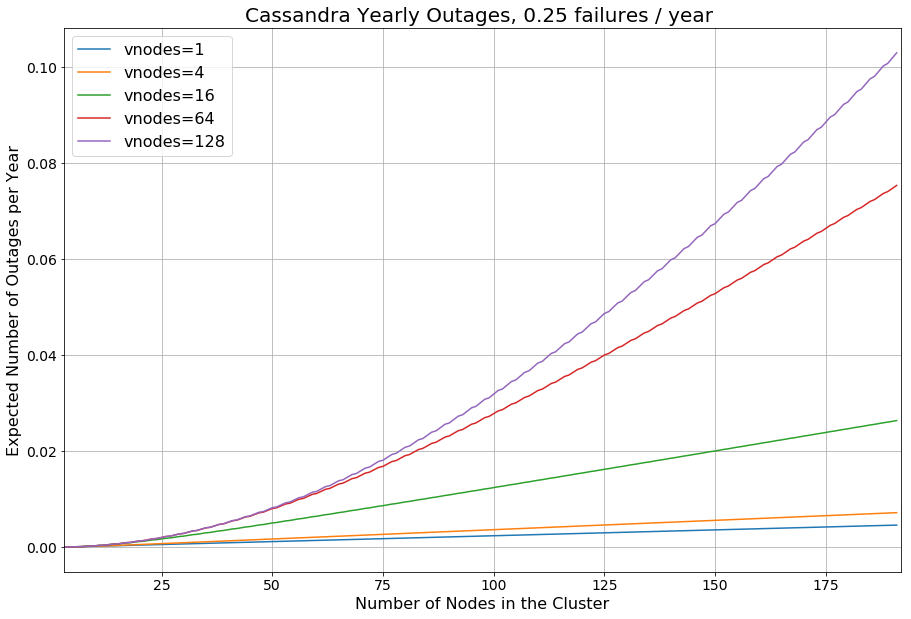

In [3]:
# Hold vnodes constant, vary size of cluster
plt.figure(figsize=(15,10))
plt.title(
    "Cassandra Yearly Outages, {1:.2f} failures / year ".format(
        vnodes, arate * year), fontsize=20)
plt.ylabel("Expected Number of Outages per Year", fontsize=16)
plt.xlabel("Number of Nodes in the Cluster", fontsize=16)
plt.gca().grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)

num_vnodes = (1, 4, 16, 64, 128)
num_nodes = range(3, 192)
for v in num_vnodes:
    outages = [compute_outage(v, arate, n, rf, bw_in, bw_out) for n in num_nodes]
    plt.plot(num_nodes, outages, label="vnodes={0}".format(v))

plt.xlim(3, 192)
plt.legend(fontsize=16)

In [21]:
import itertools
import random
import sys

def simulate(l):
    return random.expovariate(l)

def offset(values, max_value=sys.maxint):
    nvalues = values[:1] + [0] * (len(values) - 1)
    for i in range(1,len(values)):
        nvalues[i] = values[i] + nvalues[i-1]
    return [n for n in nvalues if n <= max_value]

def outage(o, f_i, t, neighbors):
    failures = 0
    neighbor_indices = range(0, len(o))
    neighbor_indices.remove(f_i)
    random.shuffle(neighbor_indices)
    for n in range(int(round(neighbors))):
        failures += near(o[neighbor_indices[n]], o[f_i], t)
    return failures

def near(a, b, t):
    failures = 0
    for i in a:
        for j in b:
            if j > i + t:
                break
            if j - i > 0 and j - i < t:
                failures += 1
    return failures

def run_simulate(l, neighbors, nodes):
    rs = []
    for r in range(5):
        o = [offset([simulate(l) for j in range(200)]) for i in range(nodes)]
        maxes = [x[-1] for x in o]
        m = max(maxes) / year
        outages_per_year = (sum([outage(o, i, recovery, neighbors) for i in range(nodes)]) / m)
        print("Run {0} gave {1:.3f} outages/year".format(r, outages_per_year))
        rs.append(outages_per_year)
    print("Simulation outages/year: ", sum(rs) / len(rs))
    
def run_simulate_naive(l, neighbors, nodes):
    p_split = p_outage_given_failure(recovery, neighbors, l)
    l_split = l * p_split
    l_global = nodes * l_split
    rs = []
    for r in range(10):
        events = 10000
        o = offset([simulate(l_global) for j in range(events)])
        ##failure_years = [int(x/year) for x in o]
        num_years = max(o) / year
        rs.append(events / num_years)
    print("Simple simulation outages/year: ", sum(rs) / len(rs))    
    
    
print(p_outage_given_failure(recovery, num_neighbors(nodes, vnodes, rf), arate))
print(vnodes, arate, nodes, rf, bw_in, bw_out, recovery, num_neighbors(nodes, vnodes, rf))
print("Predicted outages/year:", compute_outage(vnodes, arate, nodes, rf, bw_in, bw_out))
#run_simulate(arate, num_neighbors(nodes, vnodes, rf), nodes)
run_simulate_naive(arate, num_neighbors(nodes, vnodes, rf), nodes)
run_simulate(arate, num_neighbors(nodes, vnodes, rf), nodes)

0.00124540659466
256 7.92744799594e-09 96 3 125 25 2457 63.9798444518
Predicted outages/year: 0.0298897582718
Simple simulation outages/year:  0.0298214954426
Run 0 gave 0.026 outages/year
Run 1 gave 0.020 outages/year
Run 2 gave 0.026 outages/year
Run 3 gave 0.023 outages/year
Run 4 gave 0.015 outages/year
Simulation outages/year:  0.0218244556087
